# Chapter 2. Programming Probabilistically

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

seed=4321

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system

## `numpyro` primer

In [2]:
trials = 4
theta_real = 0.35  # unknown value in a real experiment
# data = stats.bernoulli.rvs(p=theta_real, size=trials)
data = dist.Bernoulli(probs=theta_real).sample(random.PRNGKey(1), (trials,))
data

DeviceArray([0, 1, 0, 0], dtype=int32)

In [3]:
def model(data):
    # a priori
    θ = numpyro.sample('θ', dist.Beta(1., 1.))
    # likelihood
    numpyro.sample('y', dist.Bernoulli(probs=θ), obs=data)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1500, num_chains=2)
mcmc.run(random.PRNGKey(1), data=data)

sample: 100%|█| 2000/2000 [00:02<00:00, 884.02it/s, 1 steps of size 9.80e-01. acc. prob=
sample: 100%|█| 2000/2000 [00:00<00:00, 6341.96it/s, 3 steps of size 1.19e+00. acc. prob


### Summarizing the posterior

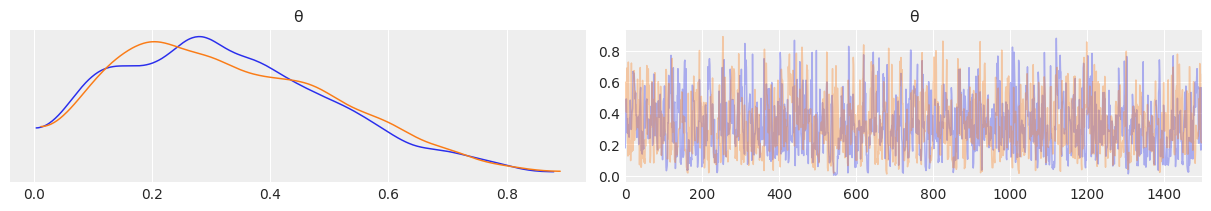

In [4]:
az.plot_trace(az.from_numpyro(mcmc), compact=False)
plt.show()

In [5]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         θ      0.33      0.18      0.30      0.05      0.61   1070.38      1.00

Number of divergences: 0


#### Posterior-based decisions

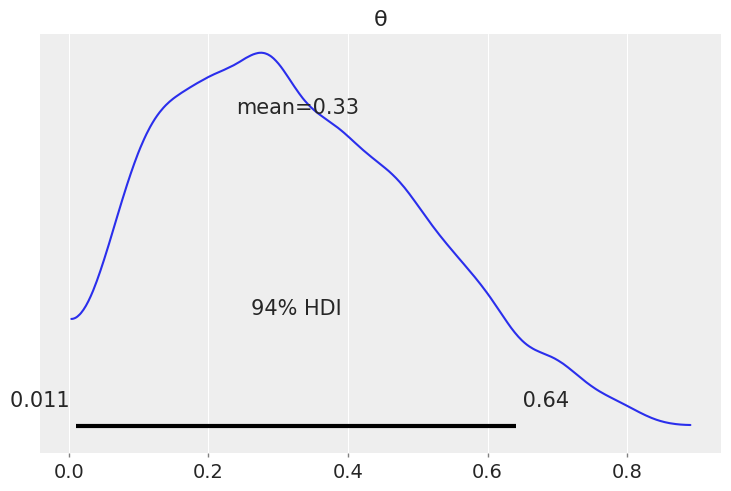

In [6]:
az.plot_posterior(az.from_numpyro(mcmc))
plt.show()

<AxesSubplot:title={'center':'θ'}>

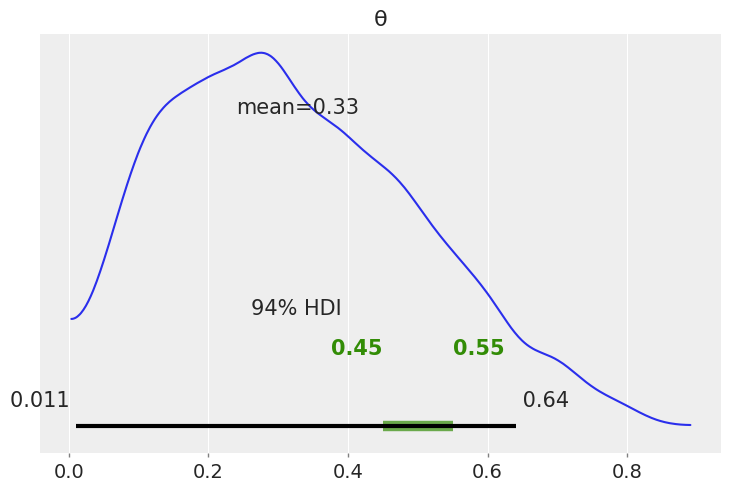

In [7]:
az.plot_posterior(az.from_numpyro(mcmc), rope=[0.45, .55])

<AxesSubplot:title={'center':'θ'}>

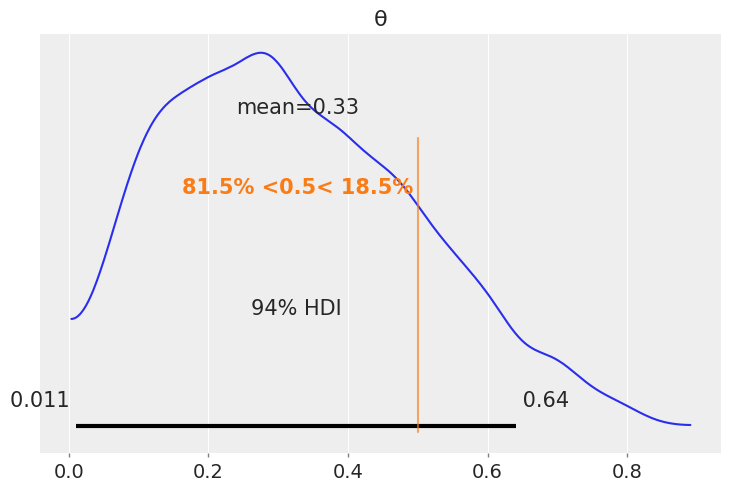

In [8]:
az.plot_posterior(az.from_numpyro(mcmc), ref_val=0.5)

In [9]:
mcmc.get_samples(group_by_chain=True)

{'θ': DeviceArray([[0.17788523, 0.3330372 , 0.4911396 , ..., 0.16403505,
               0.4801058 , 0.5643218 ],
              [0.5723461 , 0.59929645, 0.47975543, ..., 0.22258562,
               0.21222514, 0.21222514]], dtype=float32)}

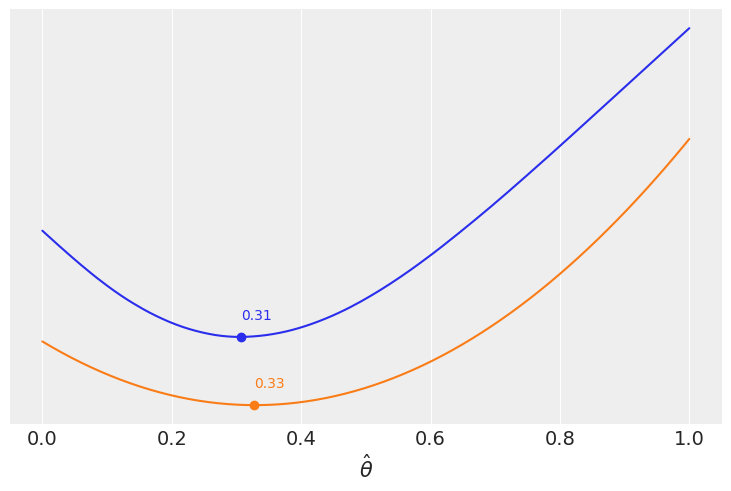

In [10]:
grid = jnp.linspace(start=0, stop=1, num=200)
θ_pos = mcmc.get_samples()["θ"]
lossf_a = [jnp.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [jnp.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = jnp.argmin(jnp.asarray(lossf))
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

In [11]:
jnp.mean(θ_pos), jnp.median(θ_pos)

(DeviceArray(0.32846668, dtype=float32),
 DeviceArray(0.30442846, dtype=float32))

Text(0.5, 0, '$\\hat \\theta$')

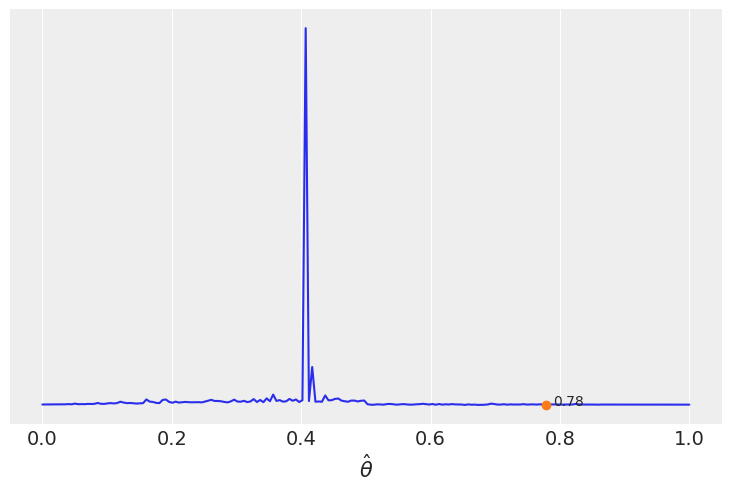

In [12]:
lossf = []
for i in grid:
    if i < 0.5:
        f = jnp.mean(jnp.pi * θ_pos / jnp.abs(i - θ_pos))
    else:
        f = jnp.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = jnp.argmin(jnp.asarray(lossf))
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')

## Gaussian inferences

In [13]:
data = pd.read_csv('../data/chemical_shifts.csv', header=None)
data.head()

,0
0,51.06
1,55.12
2,53.73
3,50.24
4,52.05


In [14]:
data = jnp.asarray(data)
data.shape

(48, 1)

([<matplotlib.axis.YTick at 0x7fd4fcb82520>], [Text(0, 0, '')])

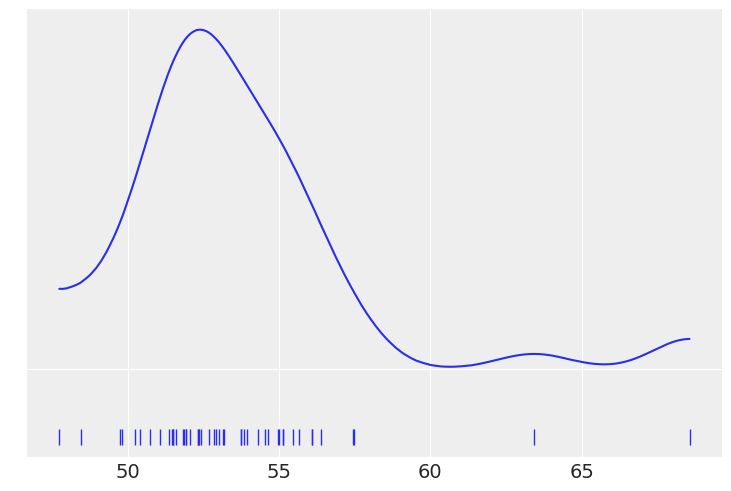

In [15]:
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

 <center><img src="../_static/imgs/B11197_02_08.png" width="600"></center>

In [19]:
def model(obs=None):
    μ = numpyro.sample('μ', dist.Uniform(low=40., high=70.))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10.))
    
    y = numpyro.sample('y', dist.Normal(loc=μ, scale=σ), obs=obs)

    
kernel = NUTS(model)
mcmc2 = MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=2)
mcmc2.run(random.PRNGKey(seed), obs=data)

sample: 100%|█| 1500/1500 [00:02<00:00, 584.49it/s, 3 steps of size 6.75e-01. acc. prob=
sample: 100%|█| 1500/1500 [00:00<00:00, 5572.06it/s, 7 steps of size 7.11e-01. acc. prob


In [33]:
def model(obs=None):
    μ = numpyro.sample('μ', dist.Uniform(low=40., high=70.))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10.))
    
    y = numpyro.sample('y', dist.Normal(loc=μ, scale=σ), obs=obs)

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim=optim.Adam(1), loss=Trace_ELBO(), obs=data)
svi_result = svi.run(random.PRNGKey(seed), num_steps=2000)
svi_result.params

100%|█| 2000/2000 [00:00<00:00, 3178.32it/s, init loss: 771.6326, avg. loss [1901-2000]:


{'auto_loc': DeviceArray([-0.20069803,  1.2389036 ], dtype=float32)}

In [34]:
samples = guide.sample_posterior(random.PRNGKey(1), svi_result.params, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         μ     53.49      0.49     53.49     52.68     54.22    994.54      1.00
         σ      3.49      0.36      3.48      2.92      4.07   1017.23      1.00



In [42]:
az.summary(samples)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.493,0.486,52.543,54.355,0.015,0.011,1007.0,909.0,NaN
σ,3.490,0.364,2.800,4.138,0.011,0.008,1006.0,940.0,NaN


In [41]:
az.plot_joint(az.from_numpyro(svi_result), var_names=['μ', 'σ'], kind='kde', fill_last=False)

AttributeError: 'SVIRunResult' object has no attribute 'get_samples'

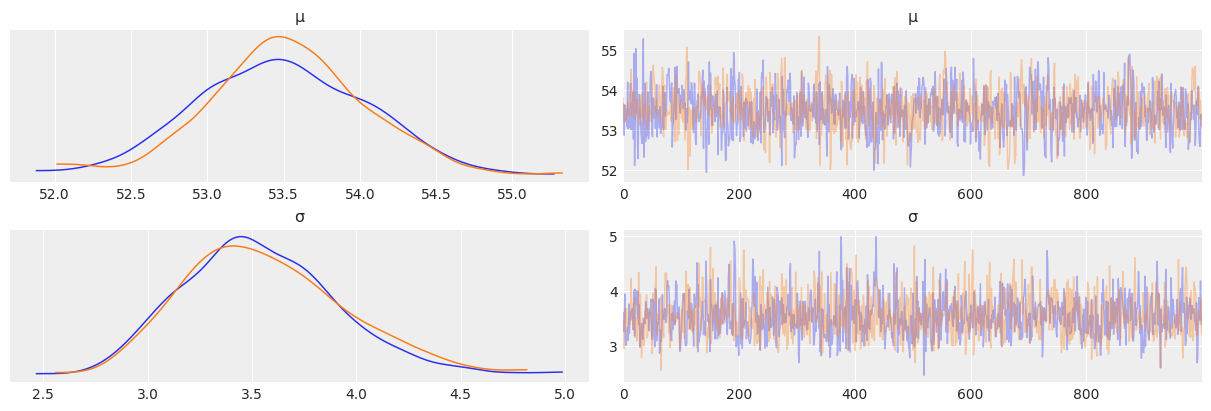

In [20]:
az.plot_trace(az.from_numpyro(mcmc2), compact=False)
plt.show()

array([<AxesSubplot:xlabel='μ', ylabel='σ'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

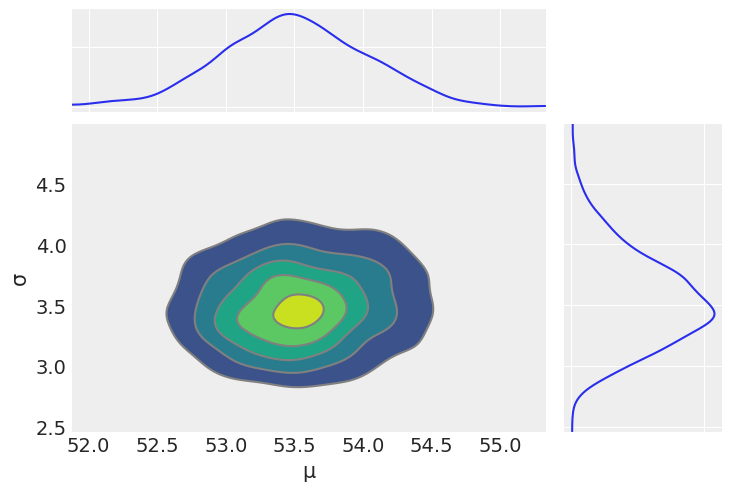

In [21]:
az.plot_joint(az.from_numpyro(mcmc2), var_names=['μ', 'σ'], kind='kde', fill_last=False)

In [19]:
mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         μ     53.49      0.05     53.50     53.40     53.57    787.94      1.00
         σ      3.42      0.04      3.42      3.36      3.48    685.76      1.00

Number of divergences: 0


In [20]:
az.summary(mcmc2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.495,0.049,53.405,53.594,0.002,0.001,795.0,675.0,1.01
σ,3.420,0.035,3.356,3.491,0.001,0.001,693.0,579.0,1.00


---

In [21]:
prior = Predictive(mcmc2.sampler.model, num_samples=10)
prior_p = prior(random.PRNGKey(seed), obs=data)

In [22]:
pred = Predictive(model=mcmc2.sampler.model, posterior_samples=mcmc2.get_samples(), return_sites=['y'])
post_p = pred(random.PRNGKey(seed), N=100)

In [23]:
# post_p['y'] = post_p['y'].squeeze()
# post_p['y'] = jnp.expand_dims(post_p['y'], axis=1) --> Seems line not needed
post_p['y'].shape

(1000, 100)

In [24]:
post_p['y'] = post_p['y'][:50]

In [25]:
post_p['y'].shape

(50, 100)

In [26]:
jnp.sort(post_p['y'][0])

DeviceArray([44.29414 , 44.349854, 46.441837, 46.689426, 46.796425,
             47.03588 , 47.583427, 47.596024, 48.212406, 48.726635,
             48.813835, 48.84052 , 49.055523, 49.085613, 49.60701 ,
             49.714584, 49.80934 , 49.83368 , 49.943848, 50.031883,
             50.160152, 50.25194 , 50.320923, 50.334843, 50.518284,
             50.518463, 50.6463  , 50.69864 , 50.728085, 50.96986 ,
             51.064117, 51.330784, 51.572712, 51.629684, 51.821022,
             51.835228, 51.87946 , 51.93214 , 52.314796, 52.3805  ,
             52.59526 , 52.771126, 52.853275, 52.88644 , 53.019768,
             53.135284, 53.27581 , 53.30327 , 53.48876 , 53.51001 ,
             53.626865, 53.722065, 53.72291 , 53.811417, 53.82796 ,
             53.831795, 53.83189 , 53.83466 , 54.084534, 54.088604,
             54.338524, 54.603535, 54.712193, 54.74976 , 54.75797 ,
             54.77956 , 54.86422 , 54.87436 , 54.945034, 54.96186 ,
             55.11813 , 55.122982, 55.267242, 55

In [27]:
# samples = az.from_numpyro(mcmc2, prior=prior_p, posterior_predictive=post_p)
samples = az.from_numpyro(mcmc2, prior=prior_p, posterior_predictive=post_p) # Priop p seems not required.
# az.summary(samples)

In [28]:
samples.groups()

['posterior',
 'posterior_predictive',
 'log_likelihood',
 'sample_stats',
 'prior',
 'prior_predictive',
 'observed_data']

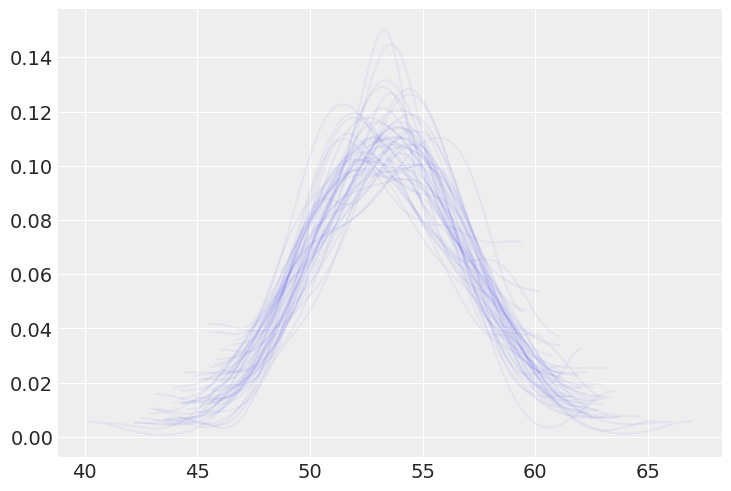

In [29]:
fig, ax = plt.subplots()
for i in post_p['y']:
    ax = az.plot_kde(i, ax=ax, plot_kwargs={'alpha': 0.05})

(40.0, 70.0)

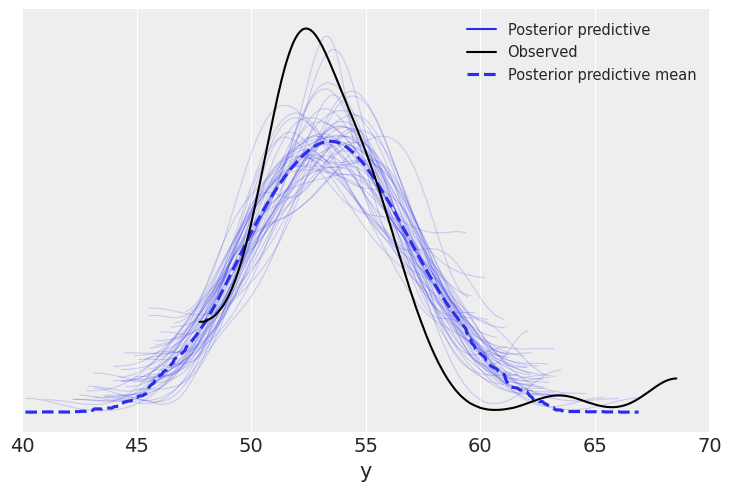

In [30]:
az.plot_ppc(samples, mean=True, observed=True)
plt.xlim(40, 70)

---

### Robust inferences

(-5.0, 5.0)

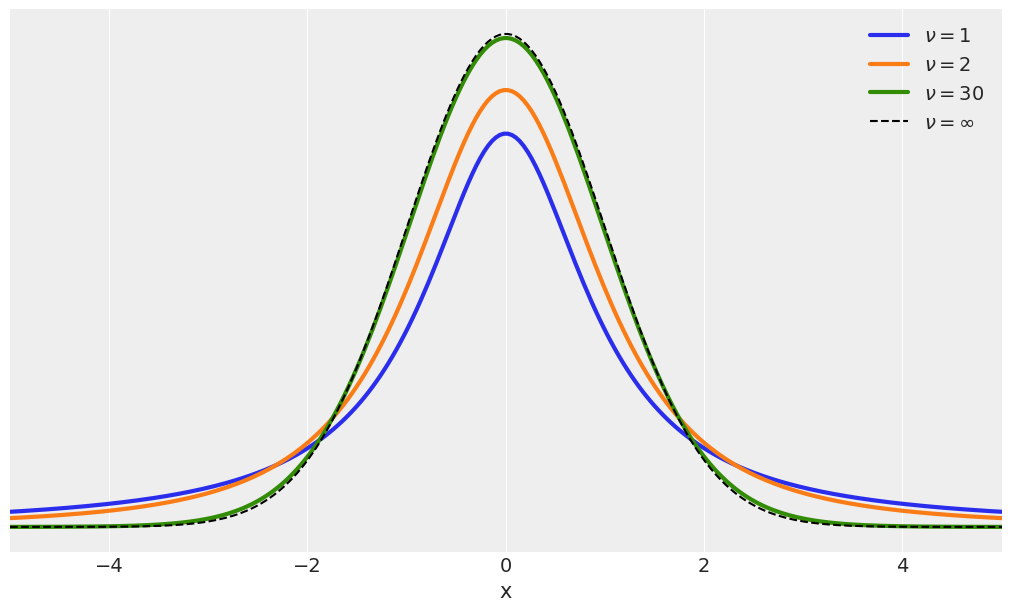

In [31]:
plt.figure(figsize=(10, 6))
x_values = jnp.linspace(start=-10, stop=10, num=500)
for df in [1, 2, 30]:
    distri = dist.StudentT(df)
    x_pdf = jnp.exp(distri.log_prob(x_values))
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = jnp.exp(dist.Normal().log_prob(x_values))
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

 <center><img src="../_static/imgs/B11197_02_13.png" width="600"></center>

In [32]:
def model(obs=None):
    μ = numpyro.sample('μ', dist.Uniform(low=40., high=75.))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10.))
    ν = numpyro.sample('ν', dist.Exponential(rate=1/30))
    
    y = numpyro.sample('y', dist.StudentT(ν, loc=μ, scale=σ), obs=obs)

    
kernel = NUTS(model)
mcmc3 = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=2)
mcmc3.run(random.PRNGKey(seed), obs=data)

sample: 100%|██████████████████████████| 1000/1000 [00:00<00:00, 3965.46it/s, 3 steps of size 6.52e-01. acc. prob=0.90]


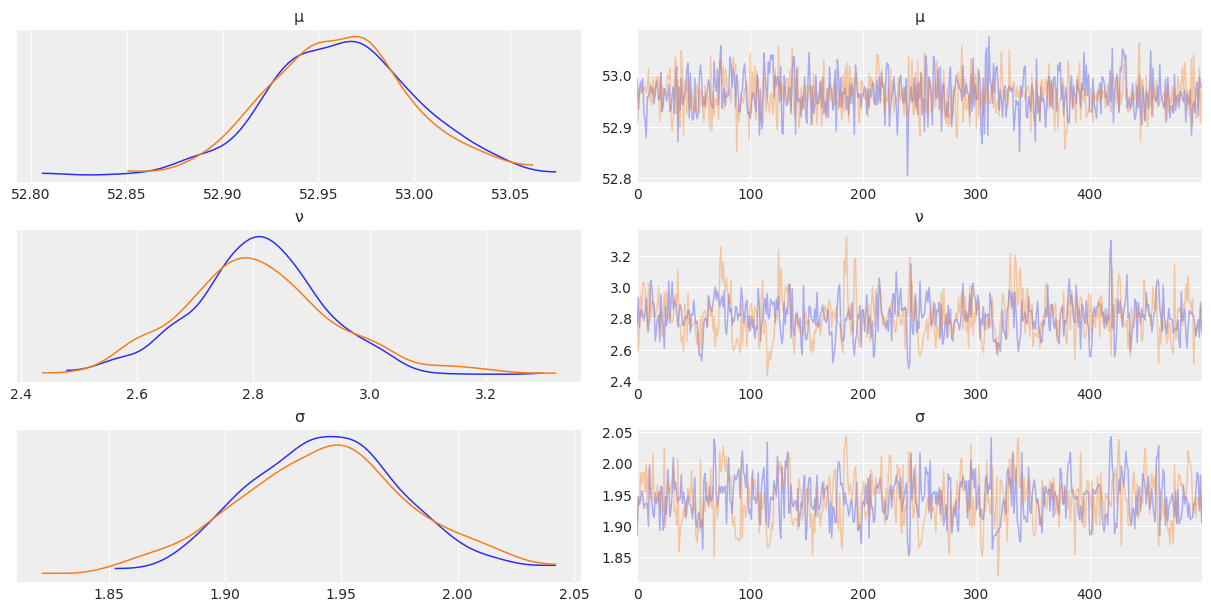

In [33]:
az.plot_trace(az.from_numpyro(mcmc3), compact=False)
plt.show()

In [34]:
az.summary(mcmc3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,52.962,0.037,52.897,53.039,0.001,0.001,1085.0,748.0,1.00
ν,2.809,0.125,2.577,3.037,0.006,0.005,380.0,429.0,1.00
σ,1.944,0.036,1.880,2.017,0.002,0.001,421.0,444.0,1.01


In [35]:
prior = Predictive(mcmc3.sampler.model, num_samples=10)
prior_p = prior(random.PRNGKey(seed), obs=data)

pred = Predictive(model=mcmc3.sampler.model, posterior_samples=mcmc3.get_samples(), return_sites=['y'])
post_p = pred(random.PRNGKey(seed), N=100)

In [36]:
post_p['y'] = post_p['y'][:100]

In [37]:
samples = az.from_numpyro(mcmc3, prior=prior_p, posterior_predictive=post_p) ## CHECK THIS

(40.0, 70.0)

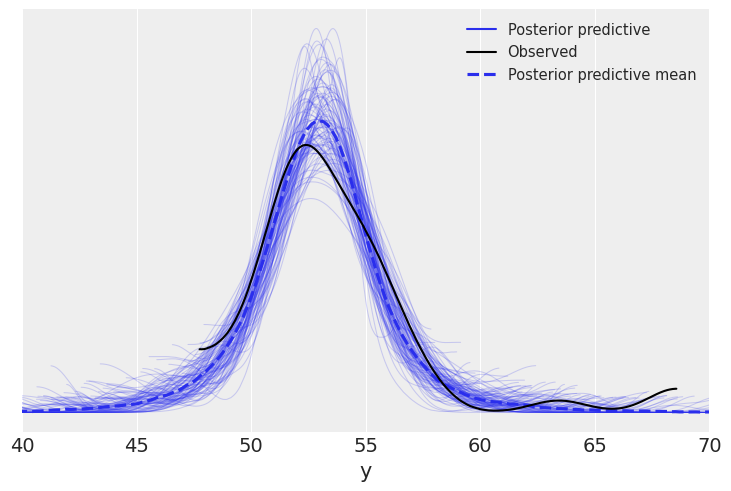

In [38]:
az.plot_ppc(samples, mean=True, observed=True, color='C0')
plt.xlim(40, 70)

# Tips example

In [39]:
tips = pd.read_csv('../data/tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


<AxesSubplot:xlabel='day', ylabel='tip'>

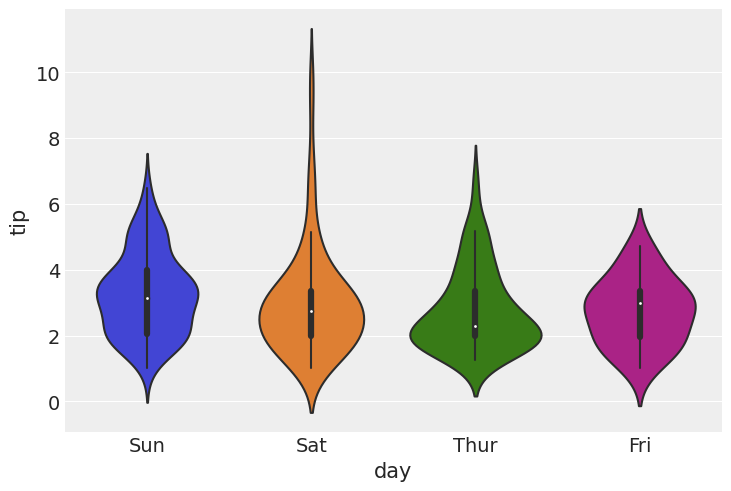

In [40]:
##### TODO: Violin plot with arviz
import seaborn as sns
sns.violinplot(x='day', y='tip', data=tips)

In [41]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(jnp.unique(idx))

In [42]:
def model(N=len(idx), obs=None):
    μ = numpyro.sample('μ', dist.Normal(loc=0., scale=10.), sample_shape=(groups,))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10.), sample_shape=(groups,))
    
    with numpyro.plate("N", N):
        numpyro.sample('y', dist.Normal(loc=μ[idx], scale=σ[idx]), obs=obs)

    
kernel = NUTS(model)
mcmc4 = MCMC(kernel, num_warmup=1000, num_samples=4000, num_chains=2)
mcmc4.run(random.PRNGKey(seed), obs=tip)

sample: 100%|██████████████████████████| 5000/5000 [00:00<00:00, 5434.91it/s, 7 steps of size 5.79e-01. acc. prob=0.91]


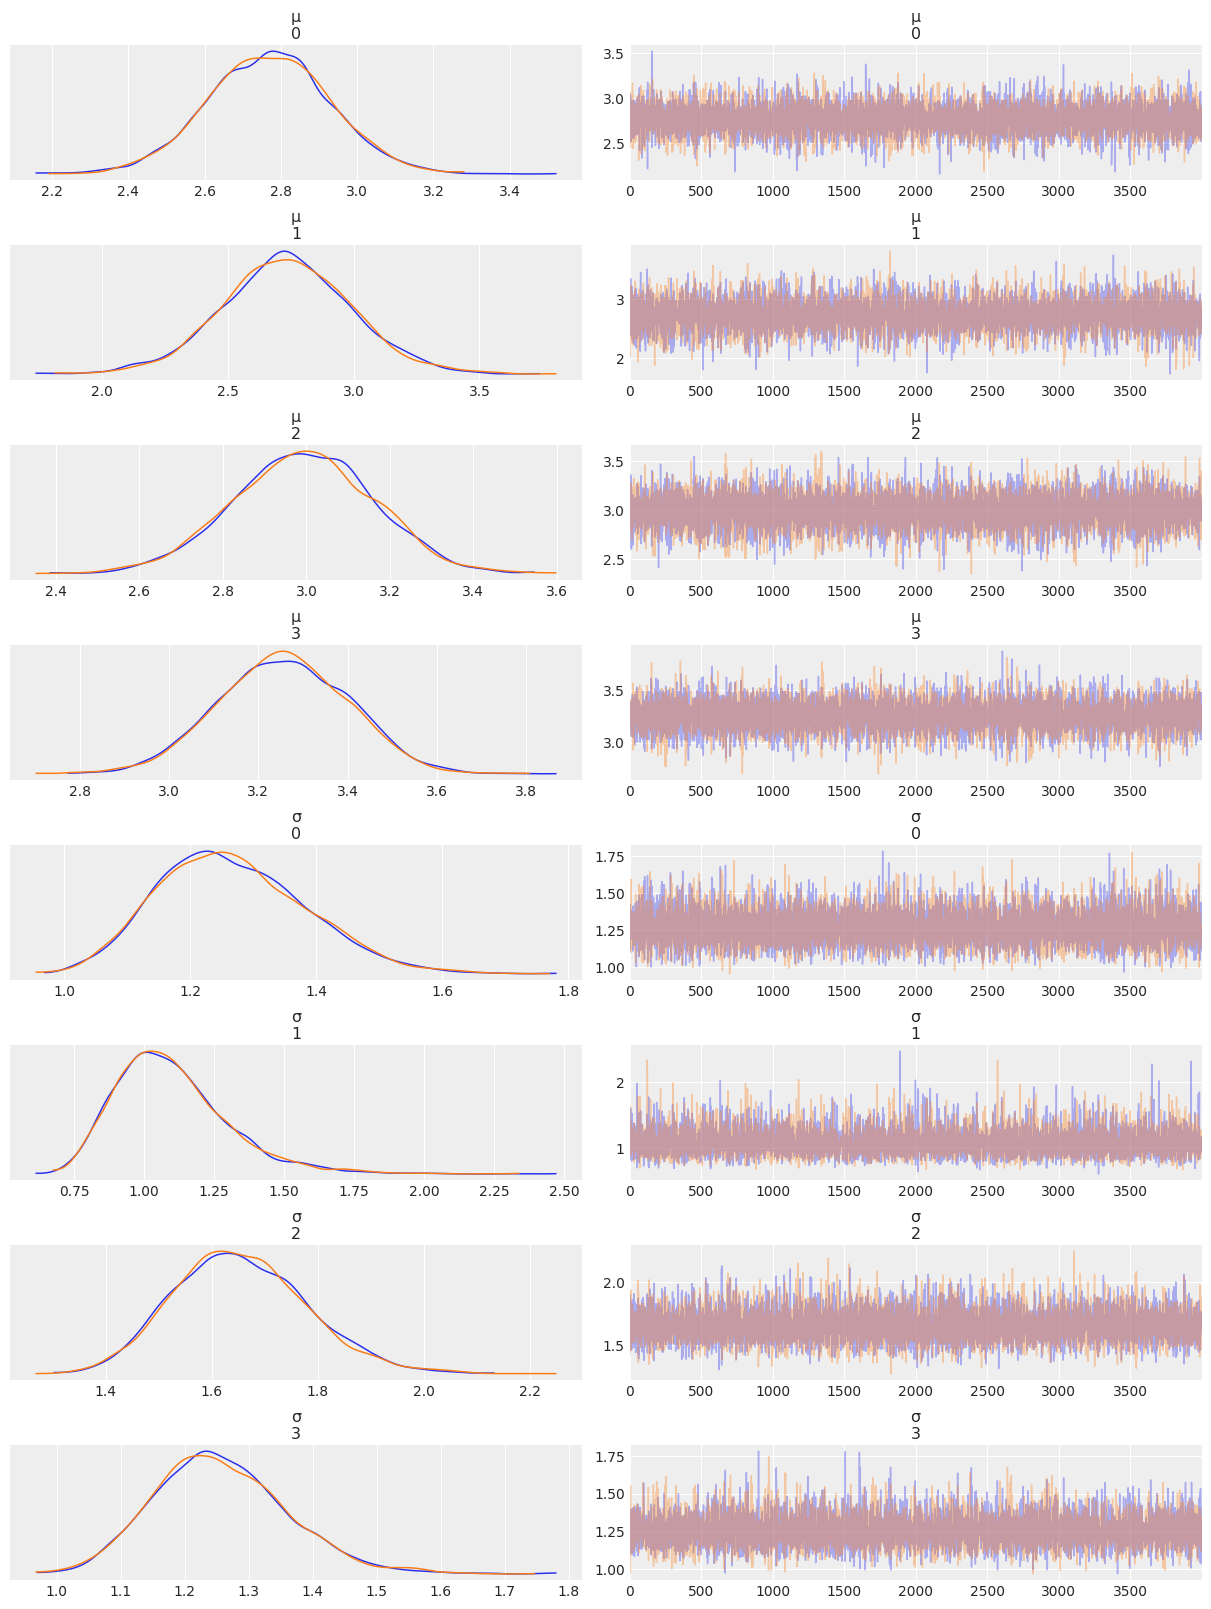

In [43]:
az.plot_trace(az.from_numpyro(mcmc4), compact=False)
plt.show()

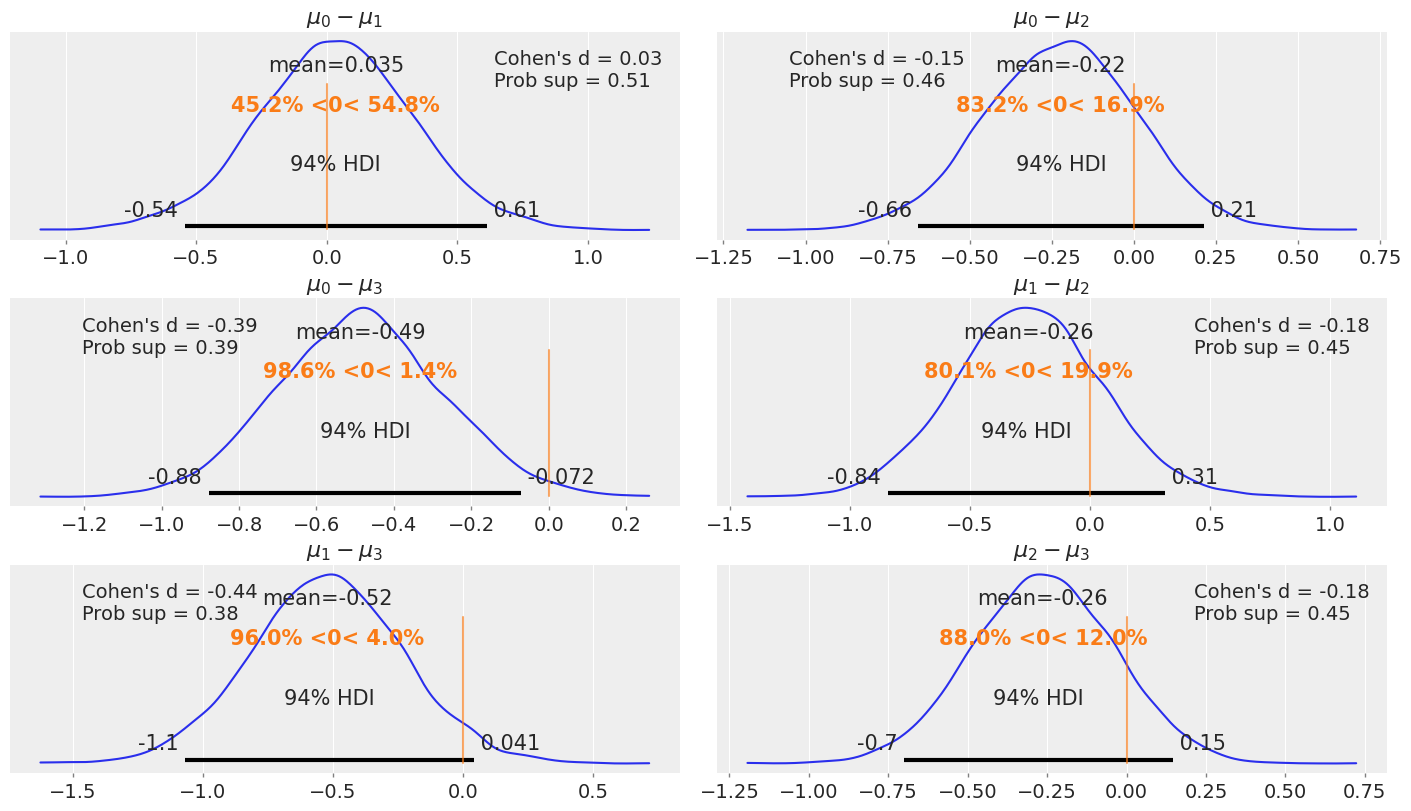

In [44]:
distri = dist.Normal()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = mcmc4.get_samples()['μ'][:, i] - mcmc4.get_samples()['μ'][:, j]
    d_cohen = (means_diff / jnp.sqrt((mcmc4.get_samples()['σ'][:, i]**2 + mcmc4.get_samples()['σ'][:, j]**2) / 2)).mean()
    ps = distri.cdf(d_cohen/(2**0.5))
#     import pdb;pdb.set_trace()
    means_diff = jnp.asarray(means_diff)
    az.plot_posterior(means_diff.copy(), ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()

# Hierarchical Models

 <center><img src="../_static/imgs/B11197_02_19.png" width="600"></center>

In [45]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]  # [3, 3, 3]  [18, 3, 3]

In [46]:
N_samples[0]

30

In [47]:
group_idx = jnp.repeat(jnp.arange(len(N_samples)), N_samples[0])
data = []

In [48]:
for i in range(0, len(N_samples)):
    data.extend(jnp.repeat(jnp.asarray([1, 0]), jnp.asarray([G_samples[i], N_samples[i]-G_samples[i]])))

In [49]:
data = jnp.asarray(data)

In [50]:
def model(obs=None):
    μ = numpyro.sample('μ', dist.Beta(1.,1.))
    κ = numpyro.sample('κ', dist.HalfNormal(scale=10.))
    θ = numpyro.sample('θ', dist.Beta(μ*κ, (1.0-μ)*κ), sample_shape=(len(N_samples),))
    
#     with numpyro.plate("N", N):
    numpyro.sample('y', dist.Bernoulli(probs=θ[group_idx]), obs=obs, sample_shape=(len(N_samples),))

    
kernel = NUTS(model)
mcmc5 = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=2)
mcmc5.run(random.PRNGKey(seed), obs=data.copy())  # .copy() needed since data in list above

sample: 100%|██████████████████████████| 3000/3000 [00:00<00:00, 6070.44it/s, 3 steps of size 4.89e-01. acc. prob=0.92]


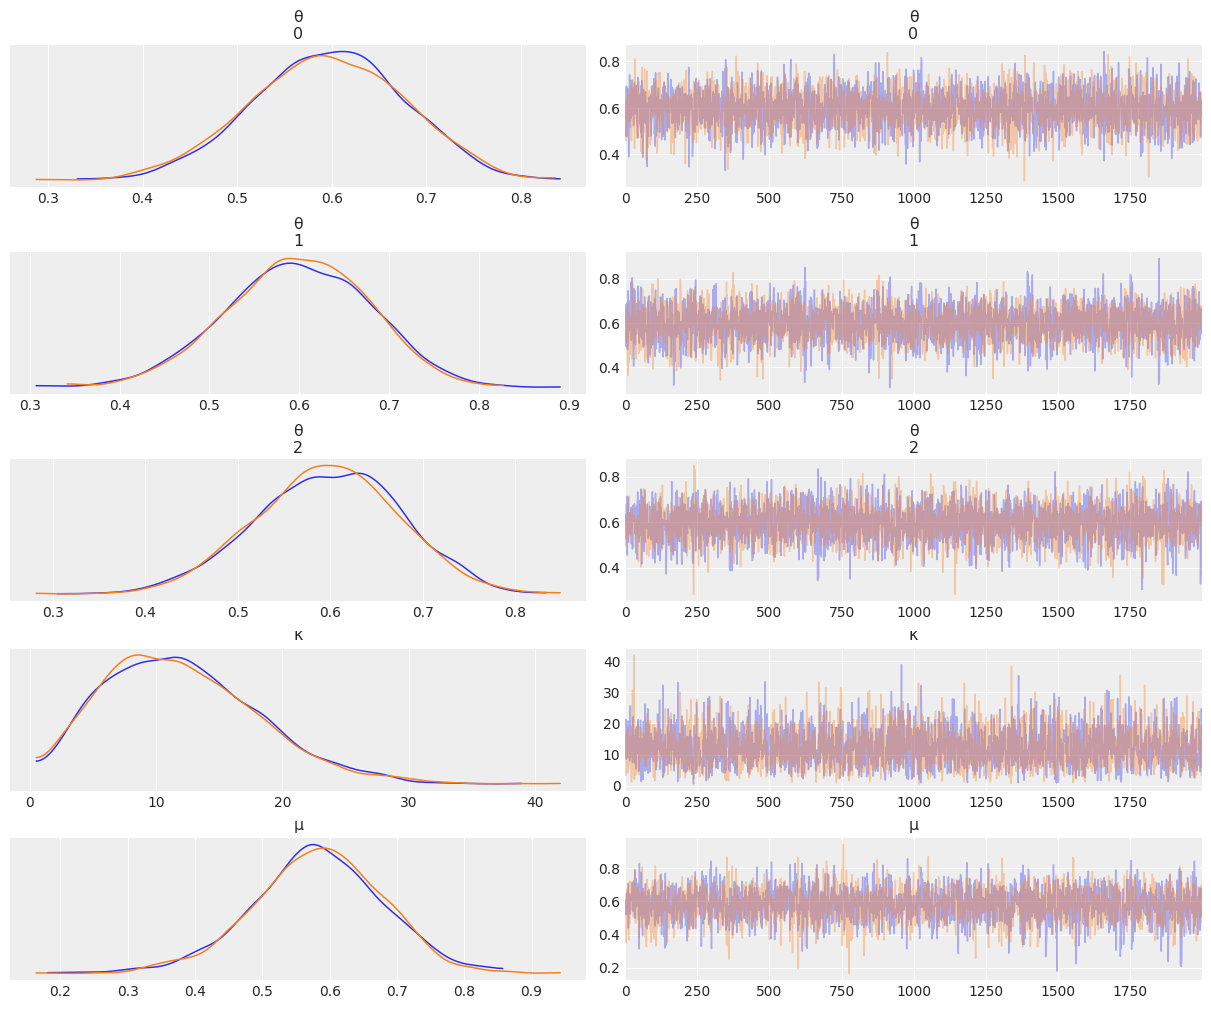

In [51]:
az.plot_trace(az.from_numpyro(mcmc5), compact=False)
plt.show()

In [52]:
az.summary(mcmc5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ[0],0.595,0.081,0.442,0.743,0.001,0.001,4082.0,3197.0,1.0
θ[1],0.598,0.080,0.441,0.737,0.001,0.001,4573.0,2541.0,1.0
θ[2],0.597,0.079,0.456,0.747,0.001,0.001,4602.0,3073.0,1.0
κ,12.039,6.076,1.485,22.795,0.109,0.077,2685.0,1685.0,1.0
μ,0.582,0.098,0.399,0.767,0.002,0.001,3011.0,2157.0,1.0


<AxesSubplot:xlabel='y'>

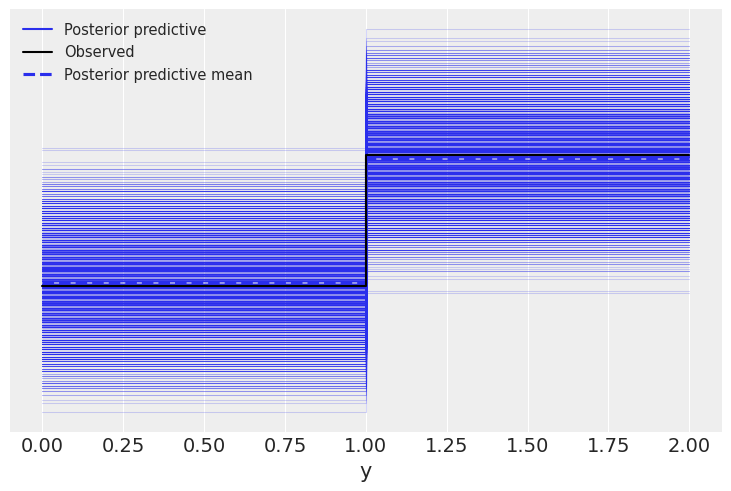

In [53]:
prior = Predictive(mcmc5.sampler.model, num_samples=10)
prior_p = prior(random.PRNGKey(seed), obs=data)

pred = Predictive(model=mcmc5.sampler.model, posterior_samples=mcmc5.get_samples(), return_sites=['y'])
post_p = pred(random.PRNGKey(seed))

samples = az.from_numpyro(mcmc5, prior=prior_p, posterior_predictive=post_p)
az.plot_ppc(samples, mean=True, observed=True, color='C0')

In [54]:
len(mcmc5.get_samples()['μ'])

4000

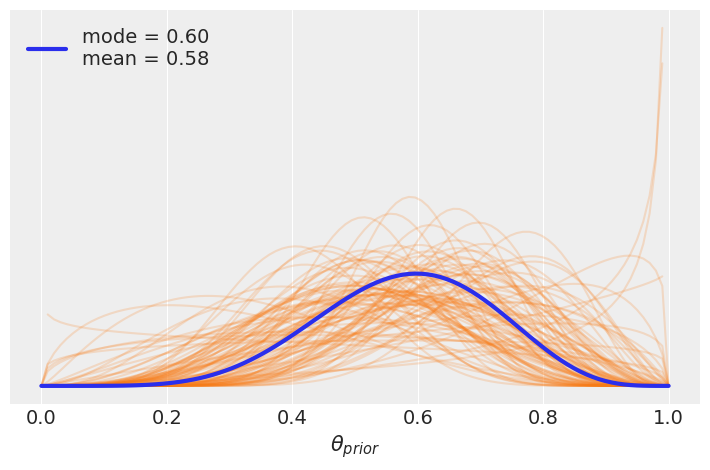

In [55]:
x = jnp.linspace(start=0, stop=1, num=100)
for i in random.randint(random.PRNGKey(1), shape=(100,), minval=0, maxval=len(mcmc5.get_samples()['μ'])):
    u = mcmc5.get_samples()['μ'][i]
    k = mcmc5.get_samples()['κ'][i]
    pdf = jnp.exp(dist.Beta(u*k, (1.0-u)*k).log_prob(x))
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = mcmc5.get_samples()['μ'].mean()
k_mean = mcmc5.get_samples()['κ'].mean()
                  
distri = dist.Beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = jnp.exp(distri.log_prob(x))
mode = x[jnp.argmax(pdf)]
mean = distri.mean
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()

In [56]:
cs_data = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(jnp.unique(idx))

In [57]:
cs_data.head()

,ID,aa,theo,exp
0,1BM8,ILE,61.18,58.27
1,1BM8,TYR,56.95,56.18
2,1BM8,SER,56.35,56.84
3,1BM8,ALA,51.96,51.01
4,1BM8,ARG,56.54,54.64


In [58]:
def model(obs=None):
    μ = numpyro.sample('μ', dist.Normal(loc=0., scale=10.), sample_shape=(groups,))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10.), sample_shape=(groups,))
    
    numpyro.sample('y', dist.Normal(loc=μ[idx], scale=σ[idx]), obs=obs, sample_shape=(len(cs_data),))

    
kernel = NUTS(model)
mcmc6 = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=2)
mcmc6.run(random.PRNGKey(seed), obs=diff)

sample: 100%|██████████████████████████| 1000/1000 [00:00<00:00, 2849.47it/s, 7 steps of size 4.74e-01. acc. prob=0.89]


In [59]:
def model(obs=None):
    # hyperpriors
    μ_μ = numpyro.sample('μ_μ', dist.Normal(loc=0., scale=10.))
    σ_μ = numpyro.sample('σ_μ', dist.HalfNormal(scale=10.))
    
    # priors
    μ = numpyro.sample('μ', dist.Normal(loc=μ_μ, scale=σ_μ), sample_shape=(groups,))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10.), sample_shape=(groups,))
    
    numpyro.sample('y', dist.Normal(loc=μ[idx], scale=σ[idx]), obs=obs, sample_shape=(len(cs_data),))

    
kernel = NUTS(model)
mcmc7 = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=2)
mcmc7.run(random.PRNGKey(seed), obs=diff)

sample: 100%|██████████████████████████| 1000/1000 [00:00<00:00, 2840.69it/s, 7 steps of size 5.15e-01. acc. prob=0.86]


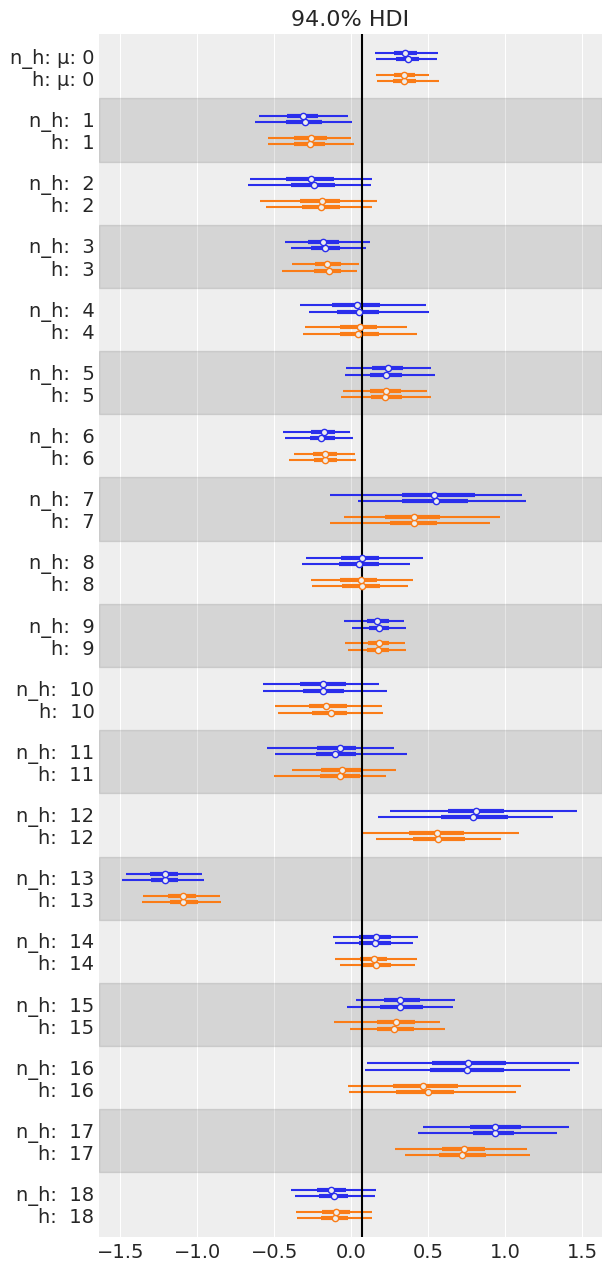

In [60]:
axes = az.plot_forest([mcmc6, mcmc7],
                         model_names=['n_h', 'h'],
                         var_names='μ', combined=False, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(jnp.mean(mcmc7.get_samples()['μ_μ']), color='k', *y_lims)